In [1]:
import pandas as pd
import pathlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.preprocessing import normalize
#import xgboost as xgb
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\light\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
lfc_mb_filt=pd.read_csv('../data/standardized_data/cleaned/lfc_mb_filt.csv')
lfc_mb_filt.head()

,ORF,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,zhang_DETA-NO_pH_7.0_vs_zhang_pH_7.0_no_NO_control,zhang_Fe_1.5mM_vs_zhang_Fe_450uM,zhang_Trp_Rescue_vs_zhang_in_vitro_control_Rescue,zhang_Tyloxapol_pH_6.5_vs_zhang_Tyloxapol_pH_4.5,zhang_Tyloxapol_pH_6.5_vs_zhang_pcit_pH_4.5,zhang_mhcii_mouse_d10_vs_zhang_wt_mouse_d10,zhang_mhcii_mouse_d45_vs_zhang_wt_mouse_d45,zhang_wt_mouse_d10_vs_zhang_input_library,zhang_wt_mouse_d45_vs_zhang_input_library,Functional_Category
0,Rv0001,-0.41,0.01,0.00,0.00,0.00,3.12,-0.06,0.00,-0.06,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,information pathways
1,Rv0002,3.28,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,information pathways
2,Rv0003,-0.03,-0.08,0.03,-1.20,0.39,3.83,0.31,0.17,-0.62,...,-0.31,1.09,-2.13,0.51,0.41,1.30,-0.49,-1.26,-2.25,information pathways
3,Rv0005,-0.22,0.14,0.13,-0.08,0.27,-2.38,0.70,-0.71,-0.37,...,-0.89,-2.36,-1.89,2.90,2.20,-4.05,0.30,0.69,-3.55,information pathways
4,Rv0006,0.53,0.37,-1.21,1.66,0.25,1.18,3.31,-0.10,-0.12,...,0.23,-1.51,4.80,-2.90,-2.05,-2.93,0.87,3.70,3.67,information pathways


In [4]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['ORF', 'Functional_Category']]

In [13]:
def rf_vanilla(mat, cols, norm_method, name):
    X=mat[cols].values
    y=mat['Functional_Category'].values
    n_classes=mat['Functional_Category'].nunique()
    #print(X,y)
    accuracy=[]
    confusion=np.zeros((n_classes, n_classes))
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if norm_method=='SMOTE':
            X_train, y_train=SMOTE().fit_resample(X_train, y_train)
            clf=RandomForestClassifier(n_estimators=100)
        if norm_method=='bal_weights':
            clf=RandomForestClassifier(n_estimators=100, class_weight='balanced')
        clf.fit(X_train,y_train)
        y_hat=clf.predict(X_test)
        confusion+=confusion_matrix(y_test, y_hat)
        accuracy.append(accuracy_score(y_test, y_hat))
    print (accuracy)
    
    confusion=confusion/3
    confusion=normalize(confusion, axis=1, norm='l1')
    col_names=['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages', 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    confusion=confusion=pd.DataFrame(confusion, columns=col_names, index=col_names)
    #confusion=pd.DataFrame(confusion, columns=clf.classes_, index=clf.classes_)
    plt.figure(figsize=(7,7))
    rc={'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 14}
    sns.set(rc=rc)
    heat=sns.heatmap(confusion, annot=True, linewidths=.1, fmt='1.2f', square=True)
    heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS', title=name)
    #return accuracy

[0.32619775739041795, 0.3391215526046987, 0.3367451381780962]


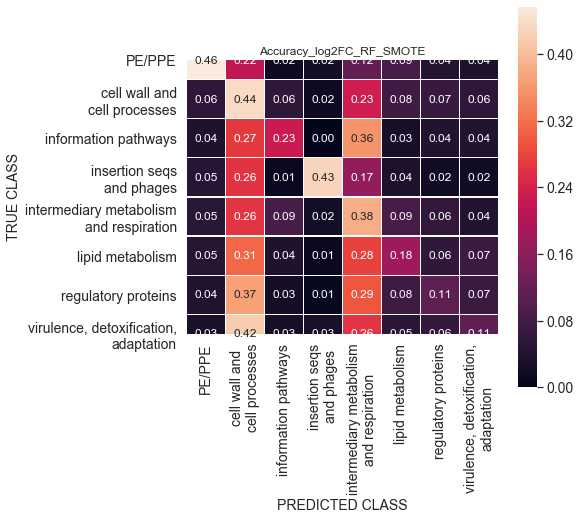

In [14]:
rf_vanilla(lfc_mb_filt, value_cols, 'SMOTE', 'Accuracy_log2FC_RF_SMOTE')

[0.3547400611620795, 0.36567926455566907, 0.368474923234391]


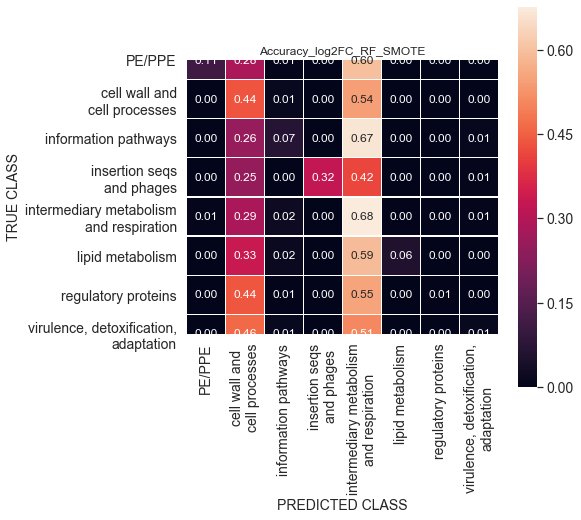

In [15]:
rf_vanilla(lfc_mb_filt, value_cols, 'bal_weights', 'Accuracy_log2FC_RF_SMOTE')

In [16]:
lfc_bin_mb_filt=pd.read_csv('../data/standardized_data/cleaned/lfc_bin_mb_filt.csv')
lfc_bin_mb_filt.head()

,ORF,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,zhang_DETA-NO_pH_7.0_vs_zhang_pH_7.0_no_NO_control_bin,zhang_Fe_1.5mM_vs_zhang_Fe_450uM_bin,zhang_Trp_Rescue_vs_zhang_in_vitro_control_Rescue_bin,zhang_Tyloxapol_pH_6.5_vs_zhang_Tyloxapol_pH_4.5_bin,zhang_Tyloxapol_pH_6.5_vs_zhang_pcit_pH_4.5_bin,zhang_mhcii_mouse_d10_vs_zhang_wt_mouse_d10_bin,zhang_mhcii_mouse_d45_vs_zhang_wt_mouse_d45_bin,zhang_wt_mouse_d10_vs_zhang_input_library_bin,zhang_wt_mouse_d45_vs_zhang_input_library_bin,Functional_Category
0,Rv0001,-0.41,0.01,0.00,0.00,0.00,3.12,-0.06,0.00,-0.06,...,0,0,0,0,0,0,0,0,0,information pathways
1,Rv0002,3.28,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,information pathways
2,Rv0003,-0.03,-0.08,0.03,-1.20,0.39,3.83,0.31,0.17,-0.62,...,0,0,0,0,0,0,0,0,0,information pathways
3,Rv0005,-0.22,0.14,0.13,-0.08,0.27,-2.38,0.70,-0.71,-0.37,...,0,0,0,0,0,0,0,0,0,information pathways
4,Rv0006,0.53,0.37,-1.21,1.66,0.25,1.18,3.31,-0.10,-0.12,...,0,0,0,0,0,0,0,0,0,information pathways


In [18]:
value_cols_lfc_bin = [col for col in lfc_bin_mb_filt.columns if col not in ['ORF', 'Functional_Category']]

[0.30275229357798167, 0.32482124616956076, 0.34083930399181167]


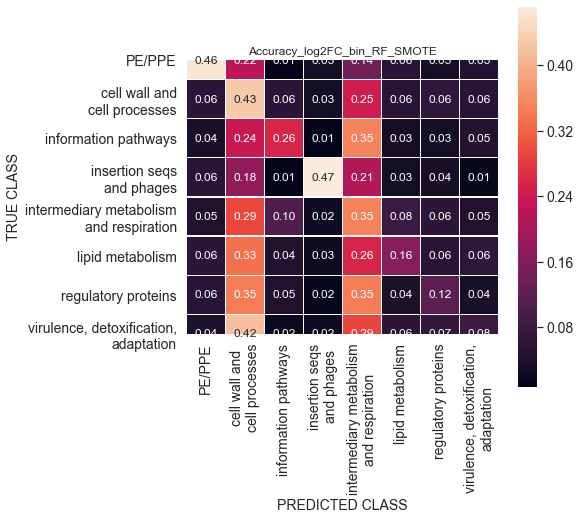

In [20]:
rf_vanilla(lfc_bin_mb_filt, value_cols_lfc_bin, 'SMOTE', 'Accuracy_log2FC_bin_RF_SMOTE')

[0.3516819571865443, 0.3503575076608784, 0.37871033776867963]


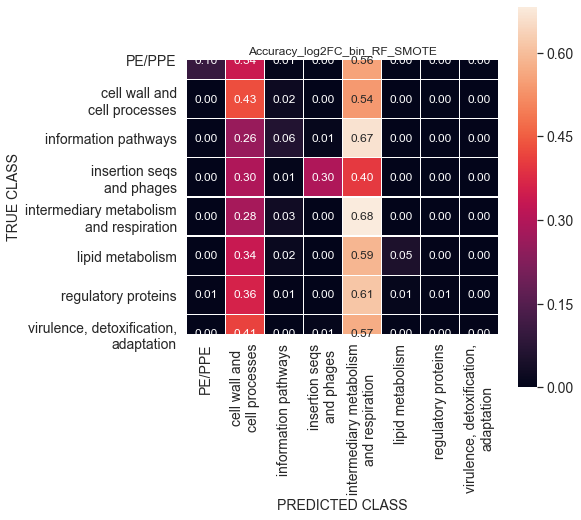

In [21]:
rf_vanilla(lfc_bin_mb_filt, value_cols_lfc_bin, 'bal_weights', 'Accuracy_log2FC_bin_RF_SMOTE')